In [11]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
from scipy.optimize import brentq
import scipy.integrate as integrate
import numba
# to print plots inline
%matplotlib inline

In [12]:
# specify parameters
alpha_k = 0.29715
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
betafirm = (1 / (1 + r))
sigma_z = 0.213
mu = 0.0
rho = 0.7605
sizez = 9
#sigma_eps = 0.2
sigma_eps = sigma_z*((1 - rho ** 2) ** (1 / 2))

In [13]:
# Compute cut-off values
N = sizez  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
print('Cut-off values = ', z_cutoffs)
# compute grid points for z
z_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
z_grid = np.exp(z_grid)
print('Grid points = ', z_grid)
# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]
        
#print('Transition matrix = ', pi)
print('pi sums = ', pi.sum(axis=0), pi.sum(axis=1))

Cut-off values =  [       -inf -0.25999639 -0.16288316 -0.09174491 -0.02975829  0.02975829
  0.09174491  0.16288316  0.25999639         inf]
Grid points =  [ 0.69553746  0.81235765  0.88149515  0.94145935  1.          1.06218075
  1.13443619  1.2309849   1.43773709]
pi sums =  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.] [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]


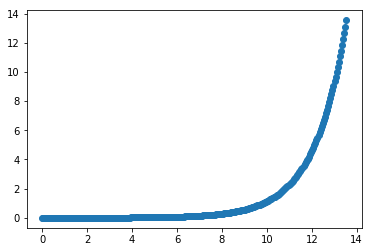

In [14]:
'''
kvec is the vector of k's
sizek is the size of the k's grid points

'''
dens = 5
# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (1 ** (1 / (1 - alpha_l))))) **   
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]
k_linear = np.linspace(lb_k, ub_k, num=sizek)
plt.scatter(k_linear, kvec)

In [15]:
# Differential functions

def c_1(k,k_prime,psi=1.08,delta=0.154):
    return psi*(k/k_prime-(1-delta))


def c_2(k,k_prime,psi=1.08,delta=0.154):
    return (psi/2)*((1-delta)**2-(k/k_prime)**2)


def op_2(z,k,alpha_l=0.65,alpha_k=0.297,w=0.7):
    return (alpha_k * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) *
              (z**(1 / (1 - alpha_l)))*(k ** ((alpha_k/ (1 - alpha_l))-1)))

In [16]:
'''
---------------------------------
Defining coleman operator
---------------------------------


'''
def coleman_operator(g, kvec, pi, z_grid, sizez, sizek, delta, betafirm, c_1, c_2, op_2, Kg = None):
    '''
    The Euler equation is given in equation (23) in lecture 1 note
    -------------------------
    parameters
    -------------------------
    g: the policy function initial guess (sizek, sizez)
    kvec: k_grid
    pi: transition matrix
    z_grid: z_grid
    sizez: length of z_grid
    sizek: length of k_grid
    delta: depreciation
    betafirm: discount factor
    c_1: function
    c_2: function
    op_2: function
    Kg: the updated policy function (sizek, sizez)
    
    '''
    if Kg is None:
        Kg = np.zeros_like(g, dtype = np.float)
    
    for i in range(sizez): #loop over z
        g_func = lambda x: np.interp(x, kvec, g[:, i])   # interpolation function to map k' to k''
        for j in range(sizek): #loop over k
            def euler(y):
                expop = 0 #calculate the expected operating profit
                for p in range(sizez):
                    expop += pi[i, p]*op_2(z_grid[p], y)
                val = expop + (1 - delta) - c_2(g_func(y), y)
                return (1 + c_1(y, kvec[j]) - betafirm*val)
            k_star = brentq(euler, 1e-10, 1e2)
            Kg[j, i] = k_star
            
    
    return Kg

In [17]:
'''
--------------------------------------
Calculate the optimal policy function
--------------------------------------

'''
#Initial settings
PFtol = 1e-6
PFdist = 7
PFmaxiter = 3000
PFiter = 1
g_init = np.zeros((sizek, sizez), dtype = np.float)
# start policy function iteration
start_time = time.clock()
g = g_init
while (PFdist > PFtol) and (PFiter < PFmaxiter):
    g_old = np.copy(g)
    Kg = coleman_operator(g, kvec, pi, z_grid, sizez, sizek, delta, betafirm, c_1, c_2, op_2)
    PFdist = (np.absolute(Kg - g_old)).max()
    PFiter += 1
    g = Kg
    #print("iteration: ", PFiter)
    #print("Distance: ", PFdist)

    
PFI_time = time.clock() - start_time
if PFiter < PFmaxiter:
    print('Policy function converged after this many iterations:', PFiter)
else:
    print('Policy function did not converge')
print('PFI took ', PFI_time, ' seconds to solve')

optK = g


Policy function converged after this many iterations: 71
PFI took  81.0164914680481  seconds to solve


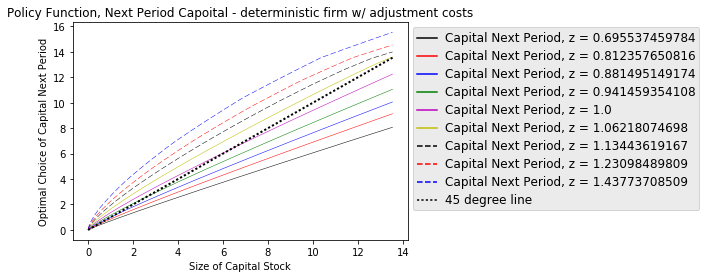

In [18]:
# Plot optimal capital stock rule as a function of firm size
PF_fig = plt.figure()
fig, ax = plt.subplots()
ax.plot(kvec, optK[:, 0], 'k', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[0]))
ax.plot(kvec, optK[:, 1], 'r', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[1]))
ax.plot(kvec, optK[:, 2], 'b', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[2]))
ax.plot(kvec, optK[:, 3], 'g', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[3]))
ax.plot(kvec, optK[:, 4], 'm', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[4]))
ax.plot(kvec, optK[:, 5], 'y', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[5]))
ax.plot(kvec, optK[:, 6], 'k--', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[6]))
ax.plot(kvec, optK[:, 7], 'r--', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[7]))
ax.plot(kvec, optK[:, 8], 'b--', lw = 0.5, label='Capital Next Period, z = '+str(z_grid[8]))
ax.plot(kvec, kvec, 'k:', lw = 2, label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - deterministic firm w/ ' +
          'adjustment costs')
plt.show()

In [10]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
